# Робота з текстом. spacy. NER

- Використання можливостей бібліотеки spacy
- Використати одну із моделей української мови для розмітки сутностей

**NER (Named Entity Recognition) або Розпізнавання іменованих сутностей** — це завдання в області обробки природної мови (NLP), яке полягає у виявленні та класифікації ключових об'єктів у тексті.

**Що робить NER?**

**NER** визначає, які частини тексту є сутностями (entities), та класифікує їх за попередньо визначеними категоріями. Це можуть бути:

- **LOC** (Location): Географічні місця (міста, країни, річки тощо).
- **PERSON** (Person): Імена людей.
- **ORG** (Organization): Організації (компанії, урядові установи, команди).
- **DATE** (Date): Дати.
- **TIME** (Time): Час.
- **MONEY** (Money): Грошові суми.
- **PERCENT** (Percentage): Відсотки.
- **PRODUCT** (Product): Продукти (техніка, ліки тощо).
- **GPE** (Geopolitical Entity): Політичні або адміністративні об'єкти.


In [80]:
# !pip install spacy
# !python -m spacy download uk_core_news_lg
    

In [81]:
import spacy

# Текст для аналізу
text = "15 грудня 2023 року в Парижі, Франція, Ілон Маск зустрівся з представниками Tesla та SpaceX. Було оголошено про фінансування в розмірі 1,5 мільярда доларів."

## Зробимо аналіз тексту з використанням україньскої моделі uk_core_news_lg

In [82]:
# Завантажуємо українську модель
nlp = spacy.load("uk_core_news_lg")

# Аналіз тексту
doc = nlp(text)

# Виводимо результати
for ent in doc.ents:
    print(f"Текст: {ent.text}, Категорія: {ent.label_}")


Текст: Парижі, Категорія: LOC
Текст: Франція, Категорія: LOC
Текст: Ілон Маск, Категорія: PER
Текст: Tesla, Категорія: ORG
Текст: SpaceX., Категорія: ORG


Нажаль ця модель не може розпізнати дати (DATE) та грошові одиниці (MONEY). Щож доведется щось робити. Як варіант додамо до NLP-пайплайну додатковий аналізатор на DATE та MONEY

**NLP-пайплайн** — це послідовність етапів обробки тексту, яку застосовують для виконання завдань у галузі обробки природної мови (NLP). У контексті бібліотеки spaCy, пайплайн — це набір компонентів, кожен з яких виконує певну задачу, наприклад токенізацію, визначення частин мови, розпізнавання іменованих сутностей тощо.

**Основні завдання NLP-пайплайну**
1. Токенізація: Розбиття тексту на токени (слова, розділові знаки, символи тощо).
2. Лематизація: Зведення слів до базової форми (наприклад, "біг" → "бігти").
3. Частини мови (POS-теги): Визначення частини мови для кожного слова.
4. NER (Named Entity Recognition): Розпізнавання і класифікація сутностей (імена, дати, місця, організації тощо).
5. Dependency Parsing: Визначення граматичних зв’язків між словами.
6. Кастомні компоненти: Додаткові етапи, наприклад, застосування регулярних виразів або специфічного аналізу тексту.

## Зробимо аналіз тексту з використанням україньскої моделі uk_core_news_lg з додаваннм свого власного компоненту який буде знаходити DATE та MONEY

In [83]:
# Це стандартний Python-модуль для роботи з регулярними виразами.
import re

# Це імпорт класу Language із бібліотеки spaCy. Ми використовуємо його для створення кастомного компонента NLP-пайплайну за допомогою декоратора @Language.component.
from spacy.language import Language

# Завантажуємо українську модель але на цей раз додамо підтримку категорій DATE та MONEY
nlp2 = spacy.load("uk_core_news_lg")

# Кастомний компонент для регулярних виразів
@Language.component("regex_ner")
def regex_ner_component(doc):
    patterns = {
        "DATE": r"\d{1,2} (січня|лютого|грудня) \d{4}",
        "MONEY": r"\d+([.,]\d+)? (мільярда|мільйона|тисяч) доларів"
    }
    matches = []
    for label, pattern in patterns.items():
        for match in re.finditer(pattern, doc.text):
            start, end = match.span()
            span = doc.char_span(start, end, label=label, alignment_mode="expand")
            if span:
                matches.append(span)

    doc.ents = list(doc.ents) + matches  # Додаємо нові сутності до наявних
    return doc

# Реєструємо компонент у spaCy
nlp2.add_pipe("regex_ner", name="regex_ner", last=True)

# Аналіз тексту
doc = nlp2(text)

# Вивід розпізнаних сутностей
for ent in doc.ents:
    print(f"Текст: {ent.text}, Категорія: {ent.label_}")


Текст: 15 грудня 2023, Категорія: DATE
Текст: Парижі, Категорія: LOC
Текст: Франція, Категорія: LOC
Текст: Ілон Маск, Категорія: PER
Текст: Tesla, Категорія: ORG
Текст: SpaceX., Категорія: ORG
Текст: 1,5 мільярда доларів, Категорія: MONEY


## Будуємо графік частотності того як часто зустрічаються певні типи сутностей у тексті

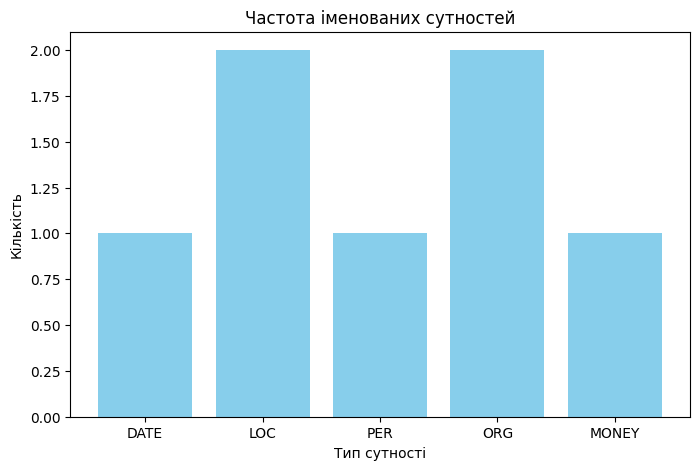

In [84]:
import matplotlib.pyplot as plt
from collections import Counter

# Підраховуємо кількість кожного типу сутностей
# Використовуємо Counter для підрахунку кількості сутностей за їх категоріями (label_)
entity_counts = Counter(ent.label_ for ent in doc.ents)

# Готуємо дані для побудови графіка
# Отримуємо список унікальних категорій сутностей
entities = list(entity_counts.keys())
# Отримуємо відповідні кількості для кожної категорії
counts = list(entity_counts.values())

# Створюємо стовпчикову діаграму
plt.figure(figsize=(8, 5))  # Встановлюємо розмір графіка
plt.bar(entities, counts, color='skyblue')  # Будуємо графік, додаємо колір
plt.title('Частота іменованих сутностей')  # Заголовок графіка
plt.xlabel('Тип сутності')  # Підпис осі X
plt.ylabel('Кількість')  # Підпис осі Y
plt.show()  # Відображаємо графік